<a href="https://colab.research.google.com/github/on-kulyashov/RQC-projects/blob/main/fermi_cyclic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pfapack
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.signal import find_peaks_cwt as peaks
from pfapack import pfaffian as pf
from numpy.fft import rfft
import numpy.matlib
import linecache
import plotly.graph_objects as go
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

seed = 53
np.random.seed(seed)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
'''
in this block all fucntions for 
Barouch's solution are introduced
'''
def hamiltonian(fields, interactions):
    '''
    calculates hamiltonian from field and bonds values
    as in Barouch(I), formula 2.4
    '''
    num_of_spins = len(fields)
    mid = np.zeros((num_of_spins, num_of_spins))
    up = np.zeros((num_of_spins, num_of_spins))
    dn = np.zeros((num_of_spins, num_of_spins))
    for position in range(num_of_spins):
        mid[position][position] = float(fields[position]) / 2
    for position in range(num_of_spins - 1):
        up[position][position + 1] = float(interactions[position]) / 4
        dn[position + 1][position] = float(interactions[position]) / 4
    a = (mid - up - dn)
    b = -(up - dn)
    ham_free = np.block([[- a, - b], [b, a]])

    ham_c_cyclic = np.copy(ham_free)
    ham_c_cyclic[0, num_of_spins - 1] += float(interactions[num_of_spins - 1]) / 4
    ham_c_cyclic[num_of_spins - 1, 0] += float(interactions[num_of_spins - 1]) / 4
    ham_c_cyclic[0, 2 * num_of_spins - 1] += float(interactions[num_of_spins - 1]) / 4
    ham_c_cyclic[2 * num_of_spins - 1, 0] += float(interactions[num_of_spins - 1]) / 4
    ham_c_cyclic[num_of_spins, num_of_spins - 1] -= float(interactions[num_of_spins - 1]) / 4
    ham_c_cyclic[num_of_spins - 1, num_of_spins] -= float(interactions[num_of_spins - 1]) / 4
    ham_c_cyclic[num_of_spins, 2 * num_of_spins - 1] -= float(interactions[num_of_spins - 1]) / 4
    ham_c_cyclic[2 * num_of_spins - 1, num_of_spins] -= float(interactions[num_of_spins - 1]) / 4

    # ham_a_cyclic = ham_c_cyclic
    # ham_a_cyclic[] += 

    return ham_c_cyclic
 
def gamma(old_occ_nums, old2new):
    '''
    calculates new occupation numbers (icluding cross-terms) at time = 0 
    from initial (old) occupation numbers
    '''
    return np.matmul(old2new, np.matmul(old_occ_nums, np.transpose(old2new)))

def gamma_t(energies, time):
    '''
    calculates new matrix_ij = <gamma_i gamma_j> at a given time
    energies = (e1, ..., en, e(n+1), ... e(2n)) - first n are non-negative eigenvalues of ham (energy/2)
    old2new - transfer matrix: (g1 ... g1^T ...)_old = old2new * (g1 ... g1^T ...)_new
    evolution is driven by multiplying by exponent of the sum of corresponding energies
    '''
    num_of_spins = len(energies) // 2
    return gamma_precalc * np.array([[np.exp(-2j*(energies[fst_g_ind] + energies[snd_g_ind]) * time) for fst_g_ind in range(2 * num_of_spins)] for snd_g_ind in range(2 * num_of_spins)])
 
def c_ij_t(newU, energies, time):
    '''
    calculates c-correlators from gamma(new)-correlators
    '''
    return np.matmul(newU, np.matmul(gamma_t(energies, time), np.transpose(newU)))

def sub_mat(c_ij_t_precalc, p, q, sub_mat_type):
    '''
    constructs submatrices S, G, Q from c-correlators
    p, q are sites for which correlator is calculated
    '''
    num_of_spins = len(c_ij_t_precalc[0]) //  2
    if sub_mat_type == 'S':
        signs = np.array([1,-1,-1,1])
    elif sub_mat_type == 'G':
        signs = np.array([1,1,-1,-1])
    elif sub_mat_type == 'Q':
        signs = np.array([1,1,1,1])
    def elem(l, m):
        if (sub_mat_type == 'S' or sub_mat_type == 'Q') and l == m:
            return 0
        cln_cmn = c_ij_t_precalc[l + num_of_spins, m + num_of_spins]
        cl_cm = c_ij_t_precalc[l, m]
        cln_cm = c_ij_t_precalc[l + num_of_spins, m]
        cl_cmn = c_ij_t_precalc[l, m + num_of_spins]
        return np.matmul(signs, np.array([cln_cmn, cln_cm, cl_cmn, cl_cm]))
    submt = np.array([[elem(a, b) for b in range(p, q)] for a in range(p, q)])
    return submt
    
def rho_x(S_whole, Q_whole, G_whole, site):
    '''
    assembles matrix for x correlations from submatrices S, G, Q and returns its pfaffian
    '''
    S = S_whole[0:site, 0:site]
    Q = Q_whole[1:(site + 1), 1:(site + 1)]
    G = G_whole[0:site, 1:(site + 1)]
    R_x = np.block([[S, G], [-np.transpose(G), Q]])
    return ((-1)**(site * (site - 1) / 2)) * pf.pfaffian((R_x - np.transpose(R_x)) / 2)

def eig_energies_states(ham):
    '''
    returns e - eigenenrgies of ham: e1, e2, ... -e1, -e2, ... and
    u - transfer: gamma = u * c
    '''
    num_of_spins = len(ham[0]) //  2
    e, u = np.linalg.eigh(ham)
    idx = np.argsort(e)[::-1]
    e = e[idx]
    e = np.concatenate((e[:num_of_spins], e[-1:num_of_spins - 1:-1]))
    u = u[:,idx]
    u = np.concatenate((u[:,:num_of_spins], u[:,-1:num_of_spins-1:-1]), axis=1)
    u1 = u[:num_of_spins, :num_of_spins]
    u2 = u[num_of_spins:, :num_of_spins]
    u = np.block([[u1, u2], [u2, u1]])
    return (e, u)

def rho_z(S_whole, Q_whole, G_whole, site):
    '''
    assembles matrix for x correlations from submatrices S, G, Q and returns its pfaffian
    '''
    def submat_z(submat_whole):
        return np.array([[submat_whole[0, 0], submat_whole[0, site]],[submat_whole[site, 0], submat_whole[site, site]]])
    S_z = submat_z(S_whole)
    Q_z = submat_z(Q_whole)
    G_z = submat_z(G_whole)
    R_z = np.block([[S_z, G_z], [-np.transpose(G_z), Q_z]])
    return -np.real_if_close(pf.pfaffian((R_z - np.transpose(R_z)) / 2))

def magn_z(c_ij_t_precalc, site):
    num_of_spins = len(c_ij_t_precalc[0]) //  2
    return np.real(2 * c_ij_t_precalc[site + num_of_spins, site] - 1)

def oc_num_0(temperature, energies_old):
    '''
    from temperature and initial energies calculates
    initial (old) occupation numbers (gamma^dagger gamma)
    '''
    num_of_spins = len(energies_old) // 2
    if temperature == 0:
        nums = np.zeros(num_of_spins)
    else:
        nums = (1 / (1 + np.exp(2 * energies_old[:num_of_spins] / temperature)))
    return np.block([[np.zeros((num_of_spins, num_of_spins)), np.diag(1 - nums)], [np.diag(nums), np.zeros((num_of_spins, num_of_spins))]])

def time_fermi(fields, interactions):
    v_max = 2 * np.average(abs(interactions)) * min(np.average(abs(fields)), 1)
    num_of_spins = len(fields)
    return num_of_spins / (2 * v_max)

def energy_from_momentum(k, av_field):
    return np.sqrt((av_field - np.cos(k))**2 + np.sin(k)**2)

def crit_moment_from_fields(av_field_1, av_field_2):
    return np.arccos((1 + av_field_1 * av_field_2) / (av_field_1 + av_field_2))

def crit_time_from_energy(crit_energy):
    return np.pi / crit_energy

def crit_time_interval(av_field_1, av_field_2):
    return crit_time_from_energy(energy_from_momentum(crit_moment_from_fields(av_field_1, av_field_2), av_field_2))

def crit_times_from_fields(simulation_time, av_field_1, av_field_2):
    t_crit = crit_time_interval(av_field_1, av_field_2)
    number_of_intervals = simulation_time // t_crit
    return t_crit * (np.arange(number_of_intervals) + 0.5)


In [ ]:
'''
this block initializes a series of experiments
'''
main_folder = "/content/drive/MyDrive/RQC/TFIM_1_quench"

boundary_conditions = "c-cyclic"
total_spins = np.array([100])  # np.arange(10, 101, 10)

temperature = 0
av_field_1 = 0.5
av_field_2 = 5 / 3
interactions_1 = lambda num_of_spins: -np.ones(num_of_spins)
fields_1 = lambda num_of_spins: av_field_1 * np.ones(num_of_spins)
interactions_2 = lambda num_of_spins: -np.ones(num_of_spins)
fields_2 = lambda num_of_spins: av_field_2 * np.ones(num_of_spins)
hamilt_params = [{"temperature": temperature, "av_field_1": av_field_1, "av_field_2": av_field_2, "fields_1": fields_1, "interactions_1": interactions_1, "fields_2": fields_2, "interactions_2": interactions_2}]

simulation_time_coeff = 3  # in fermi-times

sampling_freq = 300

def interest_spin(total_spins):
    return [(0, total_spins // 3), (0, 2 * total_spins // 3), (0, total_spins - 1)]

def disord(hamilt_params):
    return [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.25]

def fit_func(x, l):
    return np.exp(-x/l)

def fit_func_fourier_from_crit_freq(om_c):
    return lambda x, alpha, beta, gam1, gam2 : - (beta * (x + om_c) / (gam1**2 + (x + om_c)**2) + alpha * x / (gam2**2 + x**2))


In [ ]:
'''
this block computes
x-correlators
z-correlators
z-magnetization
for the given series of exp-ts
'''
for total_spins_expt in total_spins:
    for hamilt_params_expt in hamilt_params:
        temperature = hamilt_params_expt["temperature"]
        av_field_1 = hamilt_params_expt["av_field_1"]
        av_field_2 = hamilt_params_expt["av_field_2"]
        fields_1 = hamilt_params_expt["fields_1"](total_spins_expt)
        interactions_1 = hamilt_params_expt["interactions_1"](total_spins_expt)
        fields_2 = hamilt_params_expt["fields_2"](total_spins_expt)
        interactions_2 = hamilt_params_expt["interactions_2"](total_spins_expt)
        for disord_expt in disord(hamilt_params):
            fields_2 += np.random.uniform(-disord_expt, disord_expt, size=total_spins_expt)
            folder = main_folder + f"/{boundary_conditions}/total_spins_{total_spins_expt}/h1={av_field_1}_h2={av_field_2}/disorder={disord_expt}"
            !mkdir -p $folder
            '''
            Note that time_fermi (and consequently time) may vary from experiment to experiment because of random fields
            '''
            simulation_time = simulation_time_coeff * time_fermi(fields_2, interactions_2)
            nyq_freq = sampling_freq / simulation_time
            time = np.linspace(0, simulation_time, sampling_freq)
            times_crit = crit_times_from_fields(simulation_time, av_field_1, av_field_2)
            main_crit_freq = 1 / crit_time_interval(av_field_1, av_field_2)

            '''
            precalculate values for reuse
            gamma_new = old2new * gamma_old
            '''
            energies_old, c2g_old = eig_energies_states(hamiltonian(fields_1, interactions_1))
            energies_new, c2g_new = eig_energies_states(hamiltonian(fields_2, interactions_2))
            oc_num_0_precalc = oc_num_0(temperature, energies_old)
            old2new_precalc = np.matmul(np.transpose(c2g_new), c2g_old)
            gamma_precalc = gamma(oc_num_0_precalc, old2new_precalc)

            '''
            correlators construction
            '''
            correlations_x = []
            correlations_z = []
            magnetization_z = []
            for time_moment in time:
                corr_fix_time_x = []
                corr_fix_time_z = []
                magn_fix_time_z = []
                c_ij_t_precalc = c_ij_t(c2g_new, energies_new, time_moment)
                S_precalc = sub_mat(c_ij_t_precalc, 0, total_spins_expt, 'S')
                Q_precalc = sub_mat(c_ij_t_precalc, 0, total_spins_expt, 'Q')
                G_precalc = sub_mat(c_ij_t_precalc, 0, total_spins_expt, 'G')
                for site in range(total_spins_expt):
                    magn_fix_time_z.append(magn_z(c_ij_t_precalc, site))
                    if site == 0:
                        corr_fix_time_x.append(1)
                        corr_fix_time_z.append(1)
                    else:
                        corr_fix_time_x.append(rho_x(S_precalc, Q_precalc, G_precalc, site))
                        corr_fix_time_z.append(rho_z(S_precalc, Q_precalc, G_precalc, site))
                correlations_x.append(corr_fix_time_x)
                correlations_z.append(corr_fix_time_z)
                magnetization_z.append(magn_fix_time_z)
            correlations_x = np.real(np.transpose(np.array(correlations_x)))
            correlations_z = np.real(np.transpose(np.array(correlations_z)))
            magnetization_z = np.real(np.transpose(np.array(magnetization_z)))
            fourier_correl_x = rfft(correlations_x)
            fourier_extrema = []
            fourier_widths = np.linspace(2.8, 5, num=10)
            for fourier_corr_fix_spin in fourier_correl_x:
                fourier_extrema.append(peaks(fourier_corr_fix_spin, widths=fourier_widths))
            correl_x_extrema = []
            popt = []  # np.zeros(total_spins_expt)
            for spin_num in range(total_spins_expt):
                correl_x_extrema.append(peaks(fourier_correl_x[spin_num], widths=fourier_widths))
                popt.append(curve_fit(fit_func, correl_x_extrema[spin_num], [correlations_x[spin_num][fix_spin_extrema_index] for fix_spin_extrema_index in correl_x_extrema[spin_num]])[0])

            with open(folder + '/system_parameters.txt', "w") as f:
                f.write(f"temperature = {temperature} \n")
                np.savetxt(f, fields_1, delimiter=' ', newline='\n', header='fields_1 = ')
                np.savetxt(f, interactions_1, delimiter=' ', newline='\n', header='interactions_1 = ')
                np.savetxt(f, fields_2, delimiter=' ', newline='\n', header='fields_2 = ')
                np.savetxt(f, interactions_2, delimiter=' ', newline='\n', header='interactions_2 = ')
            with open(folder + '/correlations_x.txt', "w") as f:
                np.savetxt(f, correlations_x, delimiter=' ', newline='\n', header='correlations_x = ')
            with open(folder + '/correlations_z.txt', "w") as f:
                np.savetxt(f, correlations_z, delimiter=' ', newline='\n', header='correlations_z = ')
            with open(folder + '/magnetization_z.txt', "w") as f:
                np.savetxt(f, magnetization_z, delimiter=' ', newline='\n', header='magnetization_z = ')
            with open(folder + '/corr_x_decay_approx_consts.txt', "w") as f:
                np.savetxt(f, popt, delimiter=' ', newline=' ', header='decay_corr_x = \n', comments='')

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning:

divide by zero encountered in true_divide



/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[ 6.02764129e+01 -1.87184446e+06 -2.79449724e+04  2.53968706e+01]


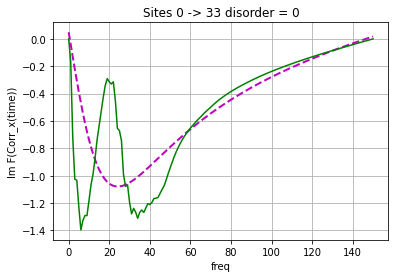

[ 6.02216951e+01 -1.98190072e+06 -2.87817524e+04  2.53786735e+01]


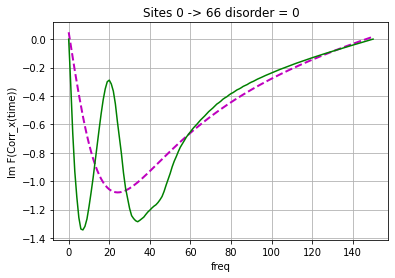

[ 12.17258648  29.42633674 -50.62396654  -2.7519145 ]


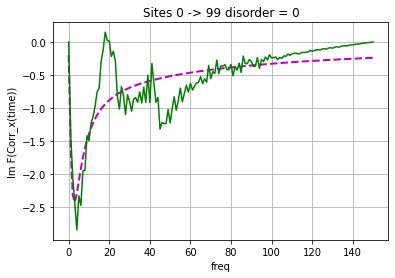

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[ 6.35044262e+01 -1.51527795e+06 -2.42235112e+04  2.70732074e+01]


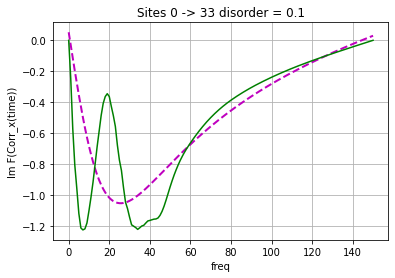

[ 6.24749567e+01 -1.76878579e+06  2.65309759e+04  2.67552288e+01]


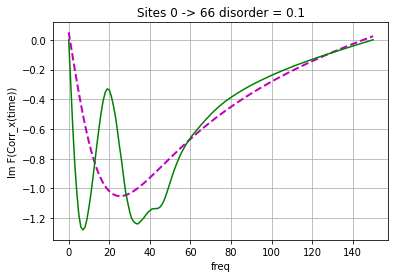

[ 10.29364202  31.41532668 -46.7342831    2.91422486]


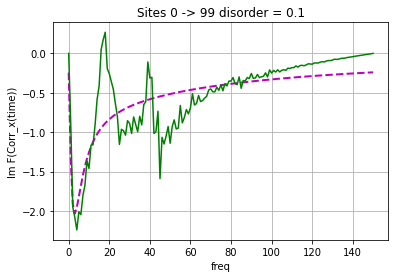

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[  66.59856752 -901.87028749  545.31343942   26.65814075]


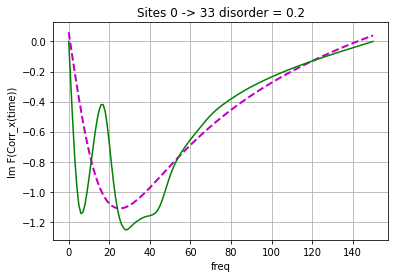

[ 6.31435146e+01 -1.11188821e+06 -2.07302310e+04  2.65153311e+01]


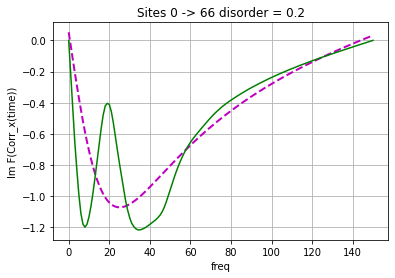

[ 10.34102188  26.91552537 -52.5109286    4.03388477]


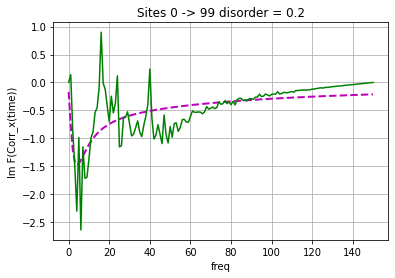

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[3.80160072e+01 2.63688026e+00 2.28625139e-03 1.95173577e+01]


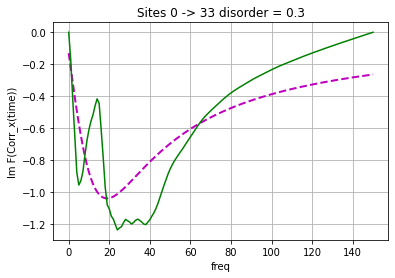

[ 3.73664983e+01  2.18019372e+00 -5.57678321e-03  2.05823533e+01]


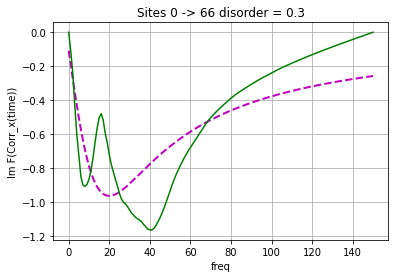

[2.65787763e+01 5.10137956e+04 2.81587688e+04 6.96156312e+00]


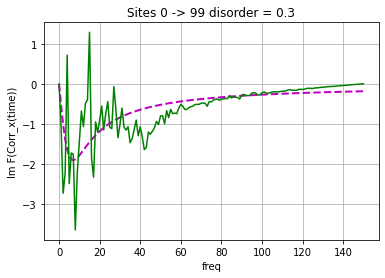

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[ 104.36417624 -197.23450537  145.57387027   36.02237305]


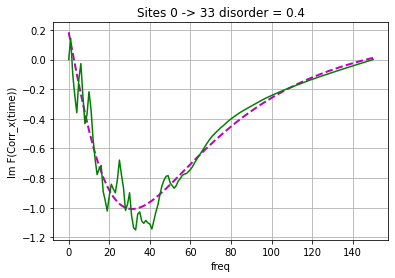

[ 102.0616477  -358.1616742  -250.32273481   43.80569724]


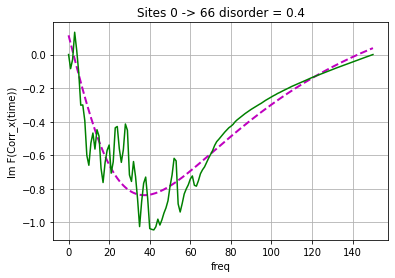

[ 3.39934157e+01 -5.21759554e+05  2.64630963e+04  1.22493738e+01]


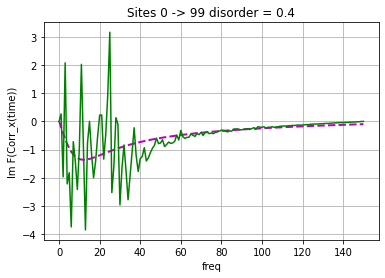

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[  92.65183233 -177.47963514  142.84856824   29.51872685]


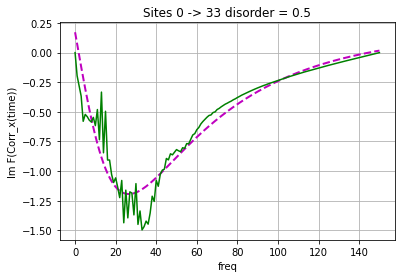

[-5.11758746 57.9572094  38.1510067  -5.44059974]


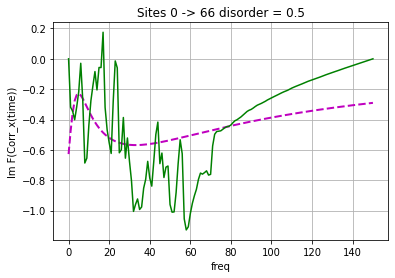

[ 1.94615158e+01 -1.08674139e+01  1.25522809e+05  3.69847856e+00]


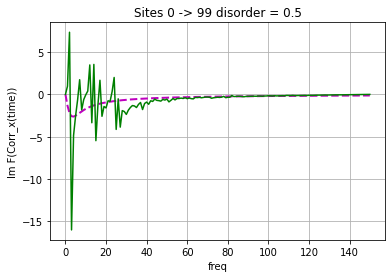

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[  90.88655607 -144.65834606 -113.81655128   26.30245842]


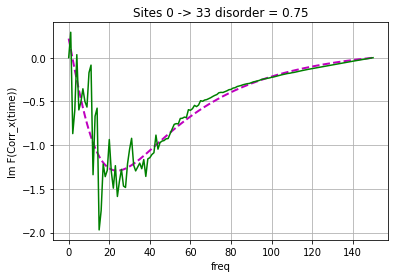

[-16.30463494  80.16130995  42.08162339   7.2389622 ]


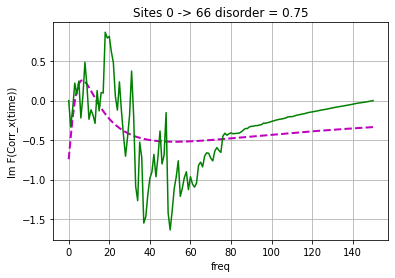

[ 3.26722486e+01 -2.66234059e+06 -5.95609251e+04 -9.89919372e+00]


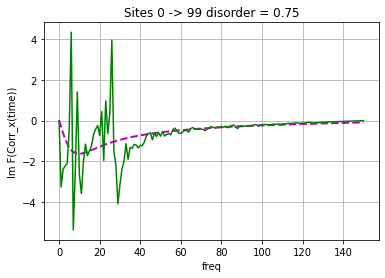

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[-3.71126183 56.52702198 38.23986369  5.4515914 ]


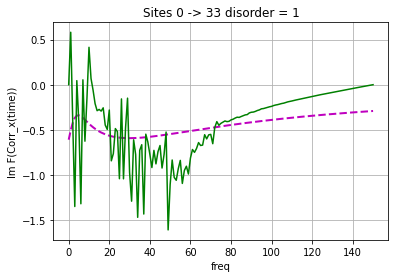

[ 107.85552323 -438.26975162 -272.89714926   45.66703784]


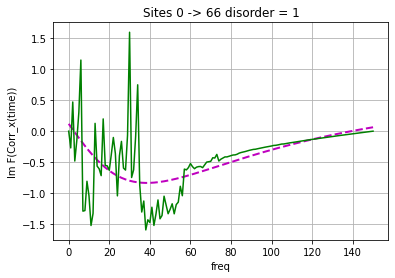

[ 168.77789547 -197.14936369   41.49023619   19.20504729]


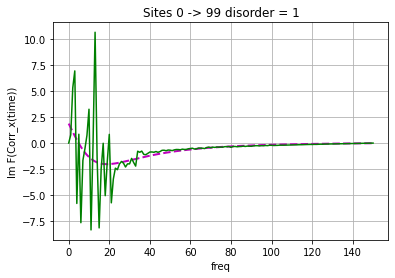

/usr/local/lib/python3.7/dist-packages/scipy/signal/wavelets.py:472: ComplexWarning:

Casting complex values to real discards the imaginary part



[ -7.00137274  41.6196827  -24.8695259    3.91593712]


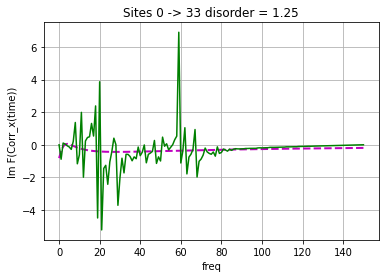

[-10.45151363  97.61012368 -57.65078128  -2.09809624]


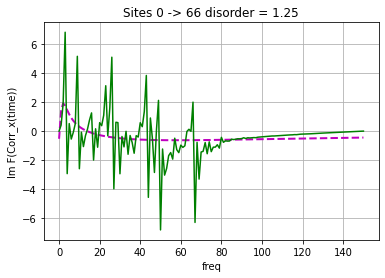

[-34.92135171  67.09201635 -42.43054521 -12.41671679]


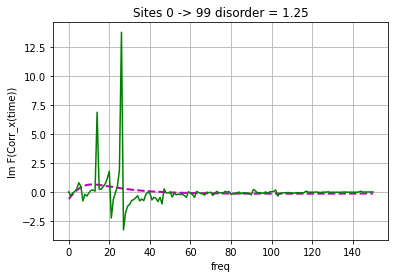

In [ ]:
'''
this block produces plots for each
experiment in the series
'''

for total_spins_expt in total_spins:
    for hamilt_params_expt in hamilt_params:
        for disord_expt in disord(hamilt_params):
            folder = main_folder + f"/{boundary_conditions}/total_spins_{total_spins_expt}/h1={av_field_1}_h2={av_field_2}/disorder={disord_expt}"
            def two_d_arr_from_file(file_name):
                line_num = 2
                arr = []
                while linecache.getline(file_name, line_num):
                    arr.append(np.fromstring(linecache.getline(file_name, line_num), sep=" "))
                    line_num += 1
                return arr
            correlations_x = two_d_arr_from_file(folder + '/correlations_x.txt')
            correlations_z = two_d_arr_from_file(folder + '/correlations_z.txt')
            magnetization_z = two_d_arr_from_file(folder + '/magnetization_z.txt')
            corr_x_decay_approx_consts = np.fromstring(linecache.getline(folder + '/corr_x_decay_approx_consts.txt', 2), sep=" ")

            simulation_time = simulation_time_coeff * time_fermi(fields_2(total_spins_expt), interactions_2(total_spins_expt))
            time_fermi_expt = time_fermi(fields_2(total_spins_expt), interactions_2(total_spins_expt))
            times_crit = crit_times_from_fields(simulation_time, av_field_1, av_field_2)
            time = np.linspace(0, simulation_time, sampling_freq)
            main_crit_freq = 1 / crit_time_interval(av_field_1, av_field_2)
            fourier_correl_x = rfft(correlations_x)
            fourier_extrema = []
            fourier_widths = np.linspace(2.8, 5, num=10)
            for fourier_corr_fix_spin in fourier_correl_x:
                fourier_extrema.append(peaks(fourier_corr_fix_spin, widths=fourier_widths))

            cool_time = int((len(time) * 1.3) // 3)

            def renorm(arr):
                return 1.3 * (arr[0:cool_time] / arr[cool_time])

            fit_func_fourier = fit_func_fourier_from_crit_freq(2 * np.pi / main_crit_freq)

            for interest_spins_expt in interest_spin(total_spins_expt):
            #     # popt = corr_x_decay_approx_consts[interest_spins_expt[1]]
            #     popt = curve_fit(fit_func, time[0:cool_time], correlations_x[interest_spins_expt[1]][0:cool_time])[0]
            #     # for t_crit in times_crit:
            #     #     plt.axvline(x=t_crit, color='k', linestyle='--')
            #     plt.plot(renorm(time), np.real_if_close(correlations_x[interest_spins_expt[1]])[0:cool_time], 'r-')
            #     plt.plot(renorm(time), fit_func(time, popt)[0:cool_time], 'g--', linewidth=2.0)
            #     plt.xlabel("time")
            #     plt.ylabel("Corr_x(time)")
            #     plt.grid()
            #     plt.title(f"Sites {interest_spins_expt[0]} -> {interest_spins_expt[1]} disorder = {disord_expt}")
            #     file_name = folder + f"/site_number={interest_spins_expt[1]}_disorder_{disord_expt}_Corr_x_time.pdf"
            #     !touch $file_name
            #     plt.savefig(file_name)
            #     plt.show()

                # for t_crit in times_crit / time_fermi_expt:
                #     if t_crit <= 1.3:
                #         plt.axvline(x=t_crit, color='k', linestyle='--')
                # plt.semilogy(renorm(time), np.real_if_close(correlations_x[interest_spins_expt[1]])[0:cool_time], 'r-')
                # # if disord_expt == 0:
                # #     plt.semilogy(renorm(time), fit_func(time, popt)[0:cool_time], 'g--', linewidth=2.0)
                # plt.xlabel("time")
                # plt.ylabel("Log(Corr_x(time))")
                # plt.grid()
                # plt.title(f"Sites {interest_spins_expt[0]} -> {interest_spins_expt[1]} disorder = {disord_expt}")
                # file_name = folder + f"/site_numbers={interest_spins_expt[1]}_disorder_{disord_expt}_Corr_x_time_semilog.pdf"
                # !touch $file_name
                # plt.savefig(file_name)
                # plt.show()

                # freq_length = len(fourier_correl_x[0])
                # for freq_crit in fourier_extrema[interest_spins_expt[1]]:
                #     plt.axvline(x=freq_crit, color='k', linestyle='--')
                # plt.axvline(x=main_crit_freq * simulation_time, color='b', linestyle='-')
                # plt.plot(np.real(fourier_correl_x[interest_spins_expt[1]]), 'r-')
                # plt.xlabel("freq")
                # plt.ylabel("Re F(Corr_x(time))")
                # plt.grid()
                # plt.title(f"Sites {interest_spins_expt[0]} -> {interest_spins_expt[1]} disorder = {disord_expt}")
                # file_name = folder + f"/site_numbers={interest_spins_expt[1]}_disorder_{disord_expt}_Re_Corr_x_time_fourier.pdf"
                # !touch $file_name
                # plt.savefig(file_name)
                # plt.show()
                imag_four = np.imag(fourier_correl_x[interest_spins_expt[1]])
                freq_space = np.arange(len(imag_four))
                popt = curve_fit(fit_func_fourier, freq_space, imag_four, maxfev=5000)[0]
                print(popt)
                plt.plot(fit_func_fourier(freq_space, *popt), 'm--', linewidth=2.0)
                plt.plot(imag_four, 'g-')
                plt.xlabel("freq")
                plt.ylabel("Im F(Corr_x(time))")
                plt.grid()
                plt.title(f"Sites 0 -> {interest_spins_expt[1]} disorder = {disord_expt}")
                file_name = folder + f"/site_numbers={interest_spins_expt[1]}_disorder_{disord_expt}_Im_Corr_x_time_fourier.pdf"
                # !touch $file_name
                # plt.savefig(file_name)
                plt.show()

                # for freq_crit in fourier_extrema[interest_spins_expt[1]]:
                #     plt.axvline(x=freq_crit, color='k', linestyle='--')
                # plt.axvline(x=main_crit_freq * simulation_time, color='b', linestyle='-')
                # plt.semilogy(np.real(fourier_correl_x[interest_spins_expt[1]]), 'r-')
                # plt.xlabel("freq")
                # plt.ylabel("Log Re F(Corr_x(time))")
                # plt.grid()
                # plt.title(f"Sites {interest_spins_expt[0]} -> {interest_spins_expt[1]} disorder = {disord_expt}")
                # file_name = folder + f"/site_numbers={interest_spins_expt[1]}_disorder_{disord_expt}_Log_Re_Corr_x_time_fourier.pdf"
                # !touch $file_name
                # plt.savefig(file_name)
                # plt.show()

                # plt.plot(renorm(time), np.real(magnetization_z[interest_spins_expt[1]])[0:cool_time], 'b-')
                # plt.xlabel("time")
                # plt.ylabel("Magn-n_z")
                # plt.grid()
                # plt.title(f"Site {interest_spins_expt[1]} magnet-n along field, disorder = {disord_expt}")
                # file_name = folder + f"/site_numbers={interest_spins_expt[1]}_disorder_{disord_expt}_Magn_z.pdf"
                # !touch $file_name
                # plt.savefig(file_name)
                # plt.show()

                # for t in range(len(time)):
                #     plt.plot(dist[1:], np.real_if_close(correlations_z[:,t], tol=1000)[1:], 'r-', label="fast")
                # plt.xlabel("distance")
                # plt.ylabel("Corr_z(dist)")
                # plt.grid()
                # plt.show()

                # dist = np.arange(num_of_spins)
                # for t in range(len(time)):
                #     plt.plot(dist[1:], np.real_if_close(correlations_x[:,t], tol=1000)[1:], 'r-', label="fast")
                # plt.xlabel("distance")
                # plt.ylabel("Corr_x(dist)")
                # plt.grid()
                # plt.show()

                # fig = go.Figure(data=[
                #     go.Surface(z=correlations_x),
                #     go.Surface(z=magnetization_z, showscale=False, opacity=0.9)
                #     ])

                # fig.update_layout(scene = dict(
                #                     xaxis_title='time',
                #                     yaxis_title='distance',
                #                     zaxis_title='Magnet-n & Correl-s'),
                #                     width=700,
                #                     margin=dict(r=20, b=10, l=10, t=10)
                #                     )

                # fig.show()

In [ ]:
print(simulation_time / simulation_time_coeff)

25.0
